In [1]:
!pip install -qqq pandas numpy matplotlib seaborn

In [2]:
!ls volume

dev  dev-llm  test


In [3]:
from pathlib import Path

In [4]:
!ls volume/test

data.jsonl			 run-2024-08-05T00:07:06.573957Z
run-2024-08-04T23:51:56.654826Z  run-2024-08-05T10:49:47.347535Z
run-2024-08-05T00:00:13.523706Z  run-2024-08-05T15:36:01.972189Z


In [12]:
run_dirs = list(sorted((Path("volume") / "test").glob("run-*")))

In [13]:
run_dirs

[PosixPath('volume/test/run-2024-08-04T23:51:56.654826Z'),
 PosixPath('volume/test/run-2024-08-05T00:00:13.523706Z'),
 PosixPath('volume/test/run-2024-08-05T00:07:06.573957Z'),
 PosixPath('volume/test/run-2024-08-05T10:49:47.347535Z'),
 PosixPath('volume/test/run-2024-08-05T15:36:01.972189Z')]

In [23]:
for run_dir in reversed(run_dirs):
    if len(list(run_dir.iterdir())) < 150:
        print(f"skipping incomplete run {run_dir}")
    else:
        break

skipping incomplete run volume/test/run-2024-08-05T15:36:01.972189Z


In [63]:
all_result_paths = list(run_dir.glob("*.jsonl_results.jsonl"))
len(all_result_paths)

164

In [31]:
import json

import pandas as pd

data = []
for path in all_result_paths:
    data += [json.loads(line) for line in path.read_text(encoding='utf-8').splitlines()]

for element in data:
    del element["completion"]

df = pd.DataFrame.from_records(data)

df.sample(10)

In [32]:
gb = df.groupby("task_id")
gb.describe()

In [33]:
passes = gb["passed"].sum()

In [34]:
import itertools
from typing import List, Union

import numpy as np

def estimate_pass_at_k(
    num_samples: Union[int, List[int], np.ndarray],
    num_correct: Union[List[int], np.ndarray],
    k: int
) -> np.ndarray:
    """
    Estimates pass@k of each problem and returns them in an array.
    """

    def estimator(n: int, c: int, k: int) -> float:
        """
        Calculates 1 - comb(n - c, k) / comb(n, k).
        """
        if n - c < k:
            return 1.0
        return 1.0 - np.prod(1.0 - k / np.arange(n - c + 1, n + 1))

    if isinstance(num_samples, int):
        num_samples_it = itertools.repeat(num_samples, len(num_correct))
    else:
        assert len(num_samples) == len(num_correct)
        num_samples_it = iter(num_samples)

    return np.array([estimator(int(n), int(c), k) for n, c in zip(num_samples_it, num_correct)])

In [35]:
pass_at_ks = {}

for k in [1, 10, 100, 1000]:
    pass_at_ks[k] = estimate_pass_at_k(1000, passes, k)

In [36]:
pass_at_k = {k: np.mean(v) for k, v in pass_at_ks.items()}
pass_at_k

{1: np.float64(0.6636280487804879),
 10: np.float64(0.8401978876608354),
 100: np.float64(0.9059827093679016),
 1000: np.float64(0.9512195121951219)}

In [43]:
plot_df = pd.DataFrame(
    {"k": pass_at_k.keys(),
     "pass@k": pass_at_k.values()}
)
plot_df["fail@k"] = 1 - plot_df["pass@k"]

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='dark')
plt.style.use("dark_background")

plt.rcParams['font.sans-serif'] = ["Inter", "Arial", "DejaVu Sans", "Liberation Sans", "Bitstream Vera Sans", "sans-serif"]

sns.despine()

sns.set_context("talk", rc={"lines.linewidth": 2.5})

<Figure size 640x480 with 0 Axes>

In [47]:
gpt4o_benchmark = 0.902

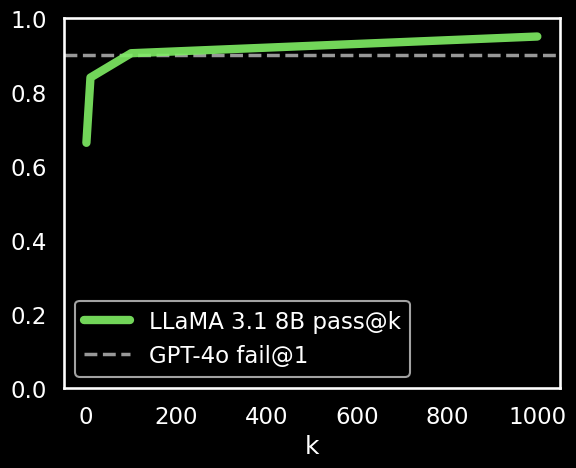

In [58]:
fg = sns.lineplot(
    x="k",
    y="pass@k",
    data=plot_df,
    color="#7FEE64",
    linewidth=6,
    alpha=0.9,
    label="LLaMA 3.1 8B pass@k"
  )

initial_lim = fg.axes.get_xlim()
fg.axes.hlines(
      gpt4o_benchmark, *initial_lim,
      linestyle="--",
      alpha=0.6,
      zorder=-1,
      label="GPT-4o fail@1"
  )
fg.axes.set_xlim(*initial_lim);
fg.axes.set_ylabel("");
fg.axes.set_ylim(0, 1);
plt.legend();

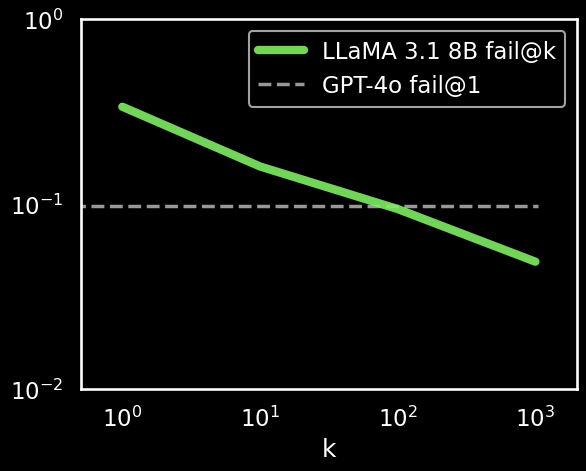

In [62]:
fg = sns.lineplot(
    x="k",
    y="fail@k",
    data=plot_df,
    color="#7FEE64",
    linewidth=6,
    alpha=0.9,
    label="LLaMA 3.1 8B fail@k"
  )

initial_lim = fg.axes.get_xlim()
fg.axes.hlines(
      1 - gpt4o_benchmark, *initial_lim,
      linestyle="--",
      alpha=0.6,
      zorder=-1,
      label="GPT-4o fail@1"
  )
fg.axes.set_xlim(*initial_lim);
fg.axes.set_ylabel("");
fg.axes.set_yscale("log")
fg.axes.set_xscale("log")
fg.axes.set_xlim(0.5, 2000);
fg.axes.set_ylim(1e-2, 1e0);
plt.legend();